# Chapter 8. Gradient Descent

In [1]:
import nbhelper

%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
from linear_algebra import distance, vector_subtract, scalar_multiply
from functools import reduce
import math, random

## The Idea Behind Gradient Descent

In [2]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

## Estimating the Gradient

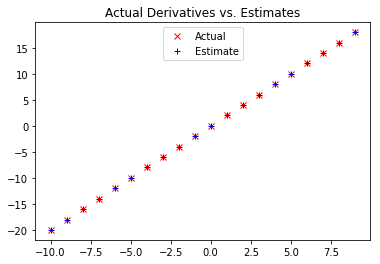

In [3]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

def square(x):
    return x * x

def derivative(x):
    return 2 * x

derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)

# plot to show they're basically the same
x = range(-10,10)
plt.plot(x, list(map(derivative, x)), 'rx', label='Actual')           # red  x
plt.plot(x, list(map(derivative_estimate, x)), 'b+', label='Estimate')  # blue +
plt.title("Actual Derivatives vs. Estimates")
plt.legend(loc=9)

In [4]:
def partial_difference_quotient(f, v, i, h):

    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

## Using the Gradient

In [5]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

#
# Compute the minimum of the sum of squares among all three-dimensional vectors.
#
print("using the gradient")

# pick a random starting point
v = [random.randint(-10,10) for i in range(3)]
print("starting v", v)

tolerance = 0.0000001

# do the gradient descent
iterations_counter = 0
while True:
    iterations_counter += 1
    #print(v, sum_of_squares(v))
    gradient = sum_of_squares_gradient(v)   # compute the gradient at v
    next_v = step(v, gradient, -0.01)       # take a negative gradient step
    if distance(next_v, v) < tolerance:     # stop if we're converging
        break
    v = next_v                              # continue if we're not

print("iterations", iterations_counter)
print("minimum v", ["{:.10f}".format(v_i) for v_i in v]) # print elements of v as floats with 10 digits after the dot
print("minimum value {:.20f}".format(sum_of_squares(v))) # print the value as a float with 20 digits after the dot

using the gradient
starting v [5, -6, 9]
iterations 728
minimum v ['0.0000020909', '-0.0000025090', '0.0000037636']
minimum value 0.00000000002483146835


## Choosing the Right Step Size

In [6]:
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

## Putting It All Together

In [7]:
#
#
# minimize / maximize batch
#
#

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

In [8]:
print("using minimize_batch")

v = [random.randint(-10,10) for i in range(3)]

v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)

print("minimum v", v)
print("minimum value {:.10f}".format(sum_of_squares(v)))

using minimize_batch
minimum v [0.0002596148429267415, -0.000519229685853483, -0.0012980742146337075]
minimum value 0.0000020220


## Stochastic Gradient Descent

In [9]:
#
# minimize / maximize stochastic
#

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)